In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import itertools
from rl.ppo.policies import ActorCriticNet
from rl.ppo.ppo import PPO
import torch
from torch import optim
from env import VanillaEnv
import time

pygame 2.1.2 (SDL 2.0.18, Python 3.9.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


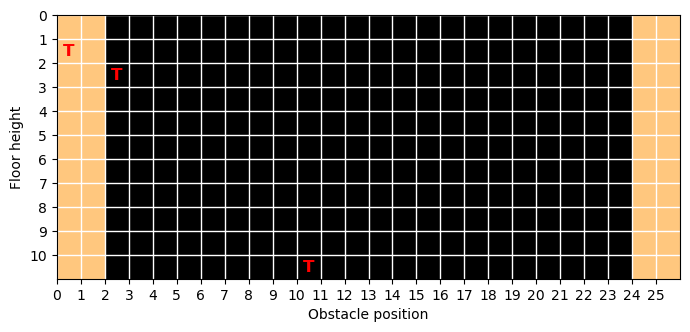

In [2]:
def plot_evaluation_grid(grid, training_positions):
    """Plots the evaluation grid."""
    fig, ax = plt.subplots(figsize=(7, 9))
    grid_x, grid_y = grid.shape
    extent = (0, grid_x, grid_y, 0)
    ax.imshow(grid.T, extent=extent, origin='lower', cmap='copper')

    x_ticks = np.arange(grid_x)
    y_ticks = np.arange(grid_y)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)

    # ax.tick_params(labelbottom=False, labelleft=False)
    ax.set_ylabel("Floor height")
    ax.set_xlabel("Obstacle position")
    
    # Loop over data dimensions and create text annotations.
    for (obstacle_pos, floor_height) in training_positions:
        pos_index = obstacle_pos
        height_index = floor_height
        ax.text(
            pos_index + 0.5,
            height_index + 0.5,
            'T',
            ha='center',
            va='center',
            color='r',
            fontsize='large',
            fontweight = 'bold')

    ax.grid(color='w', linewidth=1)
    fig.tight_layout()
    return fig

n_obstacle_pos = 26 # how many obstacle position you want to try out (paper: 27, max: 30)
n_floor_heights = 11 # how many floor heights you want to try out (paper: 11, max: 40)
obstacle_pos = np.rint(np.linspace(VanillaEnv.min_obstacle_pos, VanillaEnv.max_obstacle_pos, n_obstacle_pos)).astype(np.int8)
floor_height = np.rint(np.linspace(VanillaEnv.min_floor_height, VanillaEnv.max_floor_height, n_floor_heights)).astype(np.int8)

grid = np.zeros((len(obstacle_pos), len(floor_height)))

grid[1] = np.ones(11)
grid[0] = np.ones(11)
grid[-1] = np.ones(11)
grid[-2] = np.ones(11)

fig = plot_evaluation_grid(grid, [(0, 1), [2,2], [10,10]])
plt.show()


In [3]:
def map_conf_to_index(confs:list)->list:
    """
    Takes a list of configurations (i.e.: [(14, 0), (25, 20)]) and returns the 
    indices that correspond to the grid (i.e.: [(0, 0), (8,5)])
    """
    res = []
    for conf in confs:
        x = np.where(obstacle_pos == conf[0])[0]
        y = np.where(floor_height == conf[1])[0]
        assert len(x) == 1 and len(y) == 1, "Something wrong with the grid. Make sure the configurations are defined equally while training & evaluating"
        res.append((x[0], y[0]))
    return res

Loading model  episode-aug-15000-narrow_grid.pth


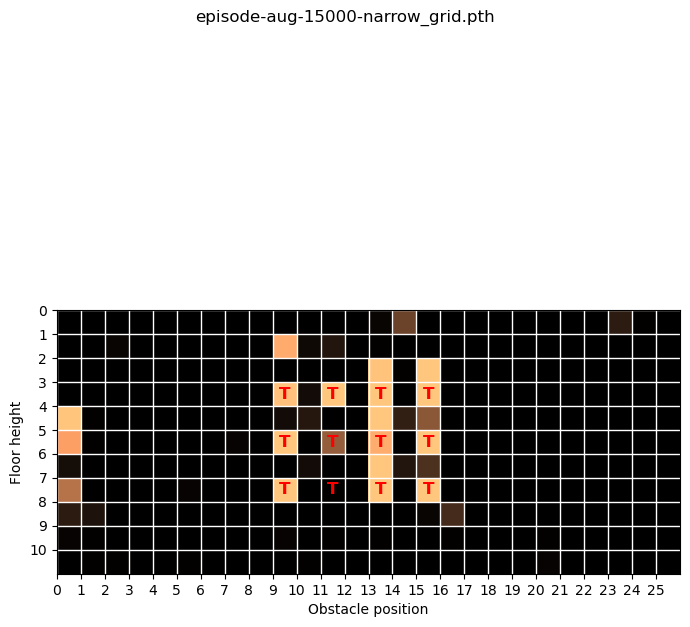

Loading model  episode-aug-30000-random_grid.pth


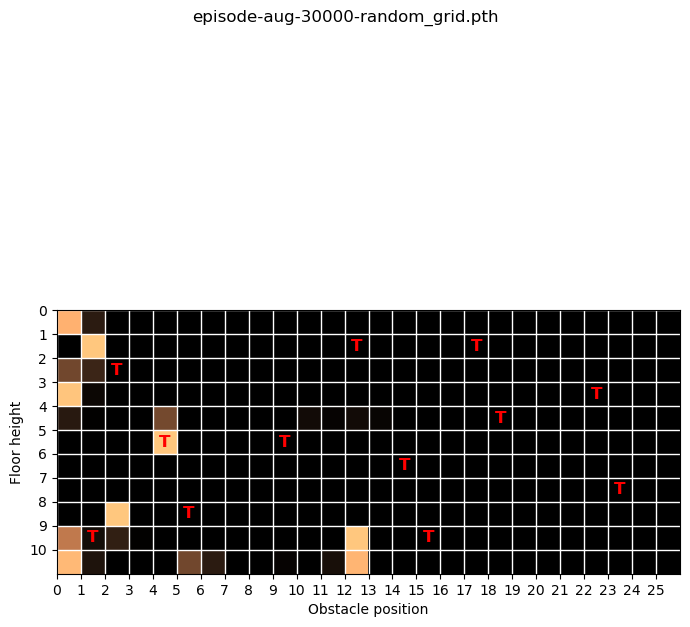

Loading model  episode-aug-30000-wide_grid.pth


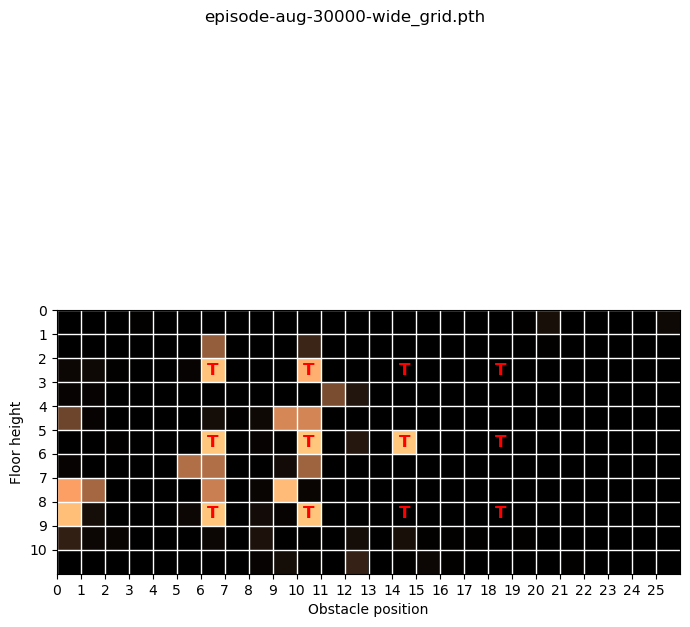

In [5]:
render = False
folder_name: str = './best-ckpts/episode-aug/'

def play_episode(model: PPO, env: VanillaEnv)->bool:
    """
    returns true of the episode is concidered solved
    """
    done = False
    episode_return = 0
    obs = env.reset()
    while not done:
        action, _ = model.policy.act(torch.FloatTensor(obs).unsqueeze(0))
        obs, rewards, done, _ = env.step(action.item())
        episode_return += 1
        if render: env.render()
    return rewards > 100

for conf_name in os.listdir(folder_name):
    print("Loading model ", conf_name)
    grid = np.zeros((len(obstacle_pos), len(floor_height)))

    for obs_pos_idx in range(len(obstacle_pos)):
        for floor_height_idx in range(len(floor_height)):
            curr_obs_pos = obstacle_pos[obs_pos_idx]
            curr_floor_height = floor_height[floor_height_idx]

            # todo load the model and check performance for all configurations
            env = VanillaEnv([(curr_obs_pos, curr_floor_height),], rendering=render)
            policy: ActorCriticNet = ActorCriticNet()
            optimizer = optim.Adam(policy.parameters(), lr=0.001)

            model = PPO(policy, env, optimizer, seed=31)
            train_info = model.load(folder_name + conf_name)


            for _ in range(100):
                is_solved = play_episode(model, env)
                if is_solved: grid[obs_pos_idx][floor_height_idx] += 0.01

    fig = plot_evaluation_grid(grid, map_conf_to_index(train_info['conf']))
    fig.suptitle(conf_name)
    plt.show()